Pair strategy is a type of **relative value** strategies or **statistical arbitrage** 
which rely on the **mean-reversion** of prices to the asset's fair value. 
They assume that prices only temporarily move away from fair value due to behavioral effects 
like overreaction or herding, or liquidity effects such as temporary market impact or long-term supply/demand friction. 



*   Find the price **correlated** HK stocks in **same sector** for Pair strategy 
*   Buy the stock when it is relatively **under-priced** to the correlated stock and sell the corresponding **over-priced** stock
*   As they're price correlated (statistically), assume they will go back to the similar price ratio later (mean reversion)
*   Hence (hopefully), the under-priced stock (bought) will goes up later while the over-priced (sold) one will drop


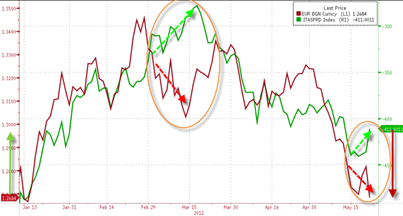

# Import libraries and helper functions

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

from datetime import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as web

# Download the font to display Chinese
!wget https://github.com/kenwkliu/ideas/raw/master/colab/data/simhei.ttf
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
CNFont = FontProperties(fname='/content/simhei.ttf')

# Yahoo Finance
!pip install yfinance
import yfinance as yf

# Google colab interactive table
%load_ext google.colab.data_table 
%matplotlib inline

# 20220202: Temp workaround for the pandas upgrade
!pip install --upgrade openpyxl

### Helper functions
# Display the stock info in Chinese or not
def useChinese(use=True):
  # return STOCK_INFO_FILE, RESEARCH_AJD_CLOSE_FILE, TEST_AJD_CLOSE_FILE
  if use:
    return 'hkStocksQuotesChi.xlsx', 'researchHKStocksAdjClosePxChi.csv', 'testHKStocksAdjClosePxChi.csv'

  else:
    return 'hkStocksQuotes.xlsx', 'researchHKStocksAdjClosePx.csv', 'testHKStocksAdjClosePx.csv'


STOCK_INFO_FILE, RESEARCH_AJD_CLOSE_FILE, TEST_AJD_CLOSE_FILE = useChinese(False)

CHART_SIZE_X, CHART_SIZE_Y = 12, 8
SMALL_CHART_SIZE_X, SMALL_CHART_SIZE_Y = 8, 6


# Plot stock pair chart
def plotPair(df, stockA, stockB, sizeX, sizeY):
  ax1 = df[stockA].plot(label=stockA, legend=True, figsize = (sizeX, sizeY))
  ax1.set_ylim(df[stockA].min(), df[stockA].max())

  ax2 = df[stockB].plot(secondary_y=True, label=stockB, legend=True, figsize = (sizeX, sizeY))
  ax2.set_ylim(df[stockB].min(), df[stockB].max())

  ax1.legend(prop=CNFont, loc=2)
  ax2.legend(prop=CNFont, loc=1)

  plt.show()


# Plot all many Pairs at the same time
def plotManyPair(pairsDf):
  for index, row in pairsDf.iterrows():
      print('\n', index, ':', row['stockA'], 'vs', row['stockB'], '(', row['corr'], ')')
      plotPair(stocks, row['stockA'], row['stockB'], SMALL_CHART_SIZE_X, SMALL_CHART_SIZE_Y)


# Filter the correlated stock pairs with the THRESHOLD
def getCorrelatedPairs(stocksCorr, THRESHOLD=0.95):
  # filter the pairs with correlation values above the THRESHOLD
  highCorr = stocksCorr[((stocksCorr >= THRESHOLD) & (stocksCorr < 1))]
  highCorr = highCorr.unstack().sort_values(ascending=False).drop_duplicates()
  highCorr.dropna(inplace=True)
  highCorrDf = highCorr.to_frame().reset_index()
  highCorrDf.rename(columns = {'level_0':'stockA', 'level_1':'stockB', 0:'corr'}, inplace=True)

  # looks up the sectors for the stocksA and stockB
  cols = ['stockA', 'stockB', 'corr', 'sector_A', 'sector_B']
  pairsDf = highCorrDf.merge(stocksFilteredInfo[['shortName', 'sector']], how='left', left_on='stockA', right_on='shortName').merge(stocksFilteredInfo[['shortName', 'sector']], how='left', left_on='stockB', right_on='shortName', suffixes=('_A', '_B'))[cols]
  pairsDf['sameSector'] = (pairsDf['sector_A'] == pairsDf['sector_B'])
  
  return pairsDf


### back test related functions

# based on the reserch data to determind the trading params (Enter/Exit Points)
def researchTradingParams(researchData, stockA, stockB, threshold=0.05, dollarValue=10000):
  cols = [stockA, stockB]
  research_df = researchData[cols].copy()
  research_df.dropna(inplace = True)

  tradingParams = {}
  tradingParams['dollarValue'] = dollarValue

  # Calculate avgPxRatio for Exit (convergence)
  research_df['ratio'] = research_df[stockA] / research_df[stockB]
  avgPxRatio = research_df['ratio'].mean()
  tradingParams['avgPxRatio'] = avgPxRatio

  # Calculate shortA_longB_ratio for Entry (Divergence)
  shortA_longB_ratio = avgPxRatio * (1 + threshold)
  tradingParams['shortA_longB_ratio'] = shortA_longB_ratio

  # Calculate longA_shortB_ratio from Entry (Divergence)
  longA_shortB_ratio = avgPxRatio * (1 - threshold)
  tradingParams['longA_shortB_ratio'] = longA_shortB_ratio

  return tradingParams


# Determind the signal and dollarValue in the test data
# signal == -1: Long stockA Short stockB
# signal == 1: Short stockA Long stockB
# signal == 0: flat position
def backTest(testData, tradingParams, stockA, stockB):
  cols = [stockA, stockB]
  backTest_df = testData[cols].copy()
  backTest_df.dropna(inplace = True)

  # Get the tradingParams
  dollarValue = tradingParams['dollarValue']
  avgPxRatio = tradingParams['avgPxRatio']
  shortA_longB_ratio = tradingParams['shortA_longB_ratio']
  longA_shortB_ratio = tradingParams['longA_shortB_ratio']

  # Calculate the Price ratio in backTest_df
  backTest_df['pxRatio'] = backTest_df[stockA] / backTest_df[stockB]
  backTest_df['dollarValue'] = dollarValue
  
  # initialize the signal to 0
  backTest_df['signal'] = 0
  signal = 0

  # Determine the signal in each row of the backTest_df
  for index, row in backTest_df.iterrows():
    pxRatio = row['pxRatio']

    # mark signal = 1 if pxRatio > shortA_longB_ratio (Diverge outside the upper band)
    if pxRatio > shortA_longB_ratio:
      signal = 1

    # mark signal = -1 if pxRatio < longA_shortB_ratio (Diverge outside the lower band)
    elif pxRatio < longA_shortB_ratio:
      signal = -1

    else:
      # continue to mark signal = 1 if previous signal == 1 and pxRatio > avgPxRatio (Trade entered but not converge back yet)
      if signal == 1 and pxRatio > avgPxRatio:
        signal = 1

      # continue to mark signal = -1 if previous signal == -1 and pxRatio < avgPxRatio (Trade entered but not converge back yet)
      elif signal == -1 and pxRatio < avgPxRatio:
        signal = -1

      else:
        signal = 0

    backTest_df.loc[index, 'signal'] = signal

  return backTest_df


# determine pSignal and nSignal for up/down markers in plot
# pSignal and nSignal is for displaying the up/down markers in plotting chart only, they're not required for backtest calculation
def addSignalMarker(backTest_df):
  backTest_df['pSignal'] = np.where(backTest_df['signal'] == 1, backTest_df['pxRatio'], np.nan)
  backTest_df['nSignal'] = np.where(backTest_df['signal'] == -1, backTest_df['pxRatio'], np.nan)

  return backTest_df


# Combine the research and backtest for a Portfolio of Pairs
def researchAndBackTestPortfolio(pairsDf, researchData, testData, printOutput=True):
  pairsPortfolioBackTest = []

  for index, row in pairsDf.iterrows():
    stockA, stockB = row['stockA'], row['stockB']
    if printOutput: print(stockA, 'vs', stockB)
    tradingParams = researchTradingParams(researchData, stockA, stockB)
    pairsPortfolioBackTest.append(backTest(testData, tradingParams, stockA, stockB)[[stockA, stockB, 'signal', 'dollarValue']])

  return pairsPortfolioBackTest


# Download and import pairslib for calculating PnL
!wget https://github.com/kenwkliu/ideas/raw/master/colab/pairslib.py
import pairslib

# 1. Source the stocks data


In [ ]:
#@title Display in Chinese or not (** Needs to run this block to take effect)
USE_CHINESE = True #@param {type:"boolean"}

STOCK_INFO_FILE, RESEARCH_AJD_CLOSE_FILE, TEST_AJD_CLOSE_FILE = useChinese(USE_CHINESE)

In [ ]:
# Source the Chinese name and stock sectors from http://www1.hket.com/finance/chart/industry-index.do

# Get stock info from Yahoo Finance
stock = yf.Ticker("0700.HK")
stock.info

In [ ]:
# Get the pre-downloaded (2020-Jul) all HK stocks information from yahoo and merged with stock sectors
# Pandas support reading Excel directly
stocksInfo = pd.read_excel('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/' + STOCK_INFO_FILE)
stocksInfo

In [ ]:
# list the unique industries names
industryNames = stocksInfo['industry'].unique()
print('Count:', len(industryNames))
print(industryNames)

In [ ]:
# list the unique sector names
sectorNames = stocksInfo['sector'].unique()
print('Count:', len(sectorNames))
print(sectorNames)

# 2. **Stock Selection**: 
Choose the set of the stocks that wer are interested to trade in our portfolios

In [ ]:
# Exploring the data 
# Look at the subset of useful columns and sort by largest marketCap
SELECTED_COLUMNS = ['code', 'quoteType', 'shortName', 'industry', 'sector', 'marketCap', 'regularMarketPreviousClose', 'averageDailyVolume10Day']

stocksInfo[SELECTED_COLUMNS].sort_values(by=['marketCap'], ascending=False)

In [ ]:
# Before we look at the stock price correlation, select only liquid equity names for the trading purpose
# thus add a new colume 'turnover' 
stocksInfo['turnover'] = round(stocksInfo['regularMarketPreviousClose'] * stocksInfo['averageDailyVolume10Day'])

# Select only EQUITY and turnover is bigger than certain numbers
QUOTE_TYPE = 'EQUITY'
MIN_TURNOVER = 100000000  # 100 millions
SELECTED_COLUMNS = ['code', 'shortName', 'industry', 'sector', 'turnover']

stocksFilteredInfo = stocksInfo[(stocksInfo.quoteType == QUOTE_TYPE) & (stocksInfo.turnover > MIN_TURNOVER) & (stocksInfo.industry != 'ETF')].reset_index()
stocksFilteredInfo.sort_values(by=['turnover'], ascending=False)[SELECTED_COLUMNS]

In [ ]:
# Industry Distribution (diversity) with an interactive pie chart
import plotly.express as px

# Count the company names per industry
industryCount = stocksFilteredInfo[['industry', 'code']].groupby(['industry']).count().reset_index()
industryCount.rename(columns={'code' : 'count'}, inplace=True)

# Concat the company names per industry
industryStocks = stocksFilteredInfo[['industry', 'shortName']].groupby(['industry'])['shortName'].apply(', '.join).reset_index()

# Sum the marketCap and turnover per industry
industryDetails = stocksFilteredInfo[['industry', 'marketCap', 'turnover']].groupby(['industry']).sum().reset_index()

# Combine all in one dataframe
industryInfo = industryCount.merge(industryStocks, on='industry', how='left')
industryInfo = industryInfo.merge(industryDetails, on='industry', how='left')

fig = px.pie(industryInfo, values='count', names='industry', hover_name='shortName', title='Industry Distribution')
fig.show()

In [ ]:
# Industry Distribution table
industryInfo.sort_values(by=['count'], ascending=False)

In [ ]:
# download the daily stock price info (Open, High, Low, Close, Volume) from Yahoo
startDate = '2020-1-1'
allStockCodes = stocksFilteredInfo['code'].to_string(index=False).replace("\n", " ")

# auto_adjust=True: The closing price is adjusted
# Tencent 5 for 1 split: https://www.stocksplithistory.com/?symbol=TCEHY
data = yf.download(allStockCodes, start=startDate, group_by='ticker', auto_adjust=True)

columnNames = []
stocksDownload = []

for code, name in zip(stocksFilteredInfo['code'], stocksFilteredInfo['shortName']):
    if code in data:
      stocksDownload.append(data[code])
      columnNames.append(name)

In [ ]:
# look at the downloaded stock price
company = "TENCENT"
#company = "騰訊控股" 

index = columnNames.index(company)
print(columnNames[index])
stocksDownload[index]

In [ ]:
# Combine the stocks adjusted closes to one pandas data frame 
closes = [stock['Close'] for stock in stocksDownload]
stockCloses = pd.concat(closes, axis=1)
stockCloses.columns = columnNames

# To prevent lookahead bias, split the data into research period and test period
# The Pairs identification and the trading parameters (Entry / Exit) calculations will be based on research period
# Data in test period to for backtesting
researchData = stockCloses.loc['2020-01-01':'2020-12-31']
testData = stockCloses.loc['2021-01-01':]

# Export the data to csv file for downloading
#researchData.to_csv(RESEARCH_AJD_CLOSE_FILE, encoding='utf_8_sig')
#testData.to_csv(TEST_AJD_CLOSE_FILE, encoding='utf_8_sig')

researchData

In [ ]:
# In case the Yahoo stock download failed, read from the prepared csv file

#researchData = pd.read_csv('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/' + RESEARCH_AJD_CLOSE_FILE, index_col=0)
#testData = pd.read_csv('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/' + TEST_AJD_CLOSE_FILE, index_col=0)

#columnNames = list(researchData.columns)
#researchData


In [ ]:
# Pick 2 stocks price chart to to show the price correlation in research period
stockA = 'TENCENT'
stockB = 'BABA-SW'
plotPair(researchData, stockA, stockB, CHART_SIZE_X, CHART_SIZE_Y)

#3. Pair Identifications


*   Run the price correlation for all stock Pair combinations
*   Using the the default [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)
*   The value is between 1 to -1 (**1**: perfectly positive correlated; **0**: No correlation; **-1**: perfectly negative correlated)

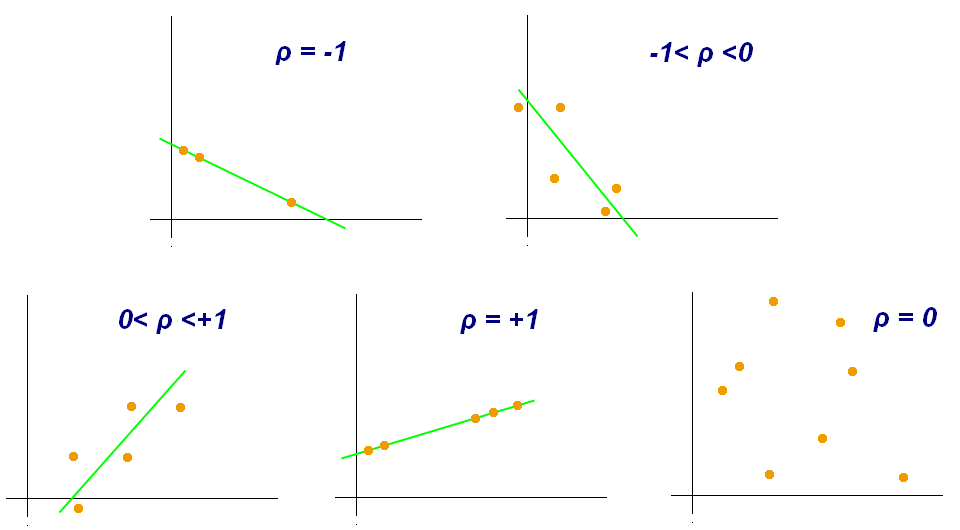 

In [ ]:
# Run the price correlation for all stock Pair combinations in research period
stocksCorr = researchData.corr()
stocksCorr.style.background_gradient(cmap='coolwarm', axis=None)

In [ ]:
# filter the pairs with correlation values above the THRESHOLD
THRESHOLD = 0.95
pairsDf = getCorrelatedPairs(stocksCorr, THRESHOLD)

pairsDf.round(4)

In [ ]:
# Pick a stock pair price chart to to show the price correlation
selected_pair = 34

PAIR_STOCK_A = pairsDf.loc[selected_pair]['stockA']
PAIR_STOCK_B = pairsDf.loc[selected_pair]['stockB']
plotPair(researchData, PAIR_STOCK_A, PAIR_STOCK_B, CHART_SIZE_X, CHART_SIZE_Y)

# Plot all the correlated Pairs with same sector
#plotManyPair(pairsDf[(pairsDf.sameSector == True)])

#4. Trading Parameters (Entry/Exit Point)

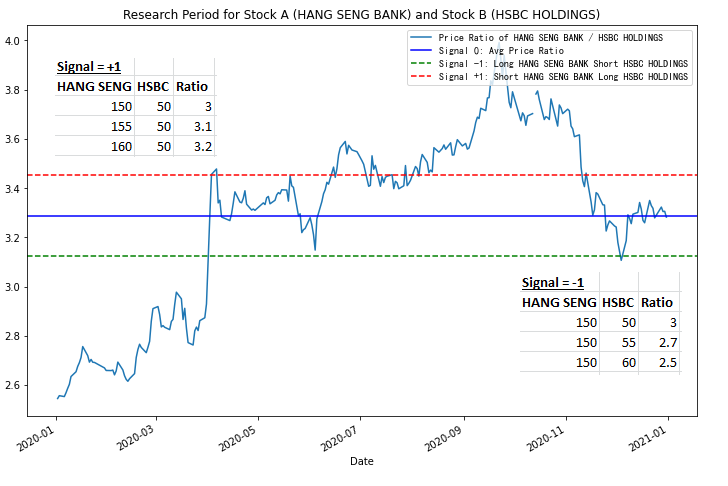

* **Price Ratio of Stock A/B**: the price relationship of stock A and B (Stock A price/ Stock B price) and it captures the **relative value**
* **Average Price Ratio of Stock A/B**: the average price ratio of the stock pair over the **research period** which represents **their long-term relationship**

* **Threshold**: define the **Divergence boundary** for trade **entry** points 

* **Entry Point** (Divergence)

 * **Signal -1: Long *under-value* Stock A and Short *over-value* Stock B** when the price ratio **drops below the divergence threshold** than the average price ratio. It happens when stock A drops relatively more than stock B or stock A rises relatively less than stock B. Hence stock A is now relatively under-value to stock B

 * **Signal +1: Short *over-value* Stock A and Long *under-value* Stock B** when price ratio **rises above the divergence theshold** than the average price ratio. It happens when stock A drops relatively less than stock B or stock A rises relatively more than stock B. Hence stock A is now relatively over-value to stock B

* **Exit Point** (Convergence)

 * **Signal 0: Rewind the Position** if already created the above long/short positions, **reverse the above trade to close out the positions** when the stock pair price ratio **reverse back to the average price ratio**


In [ ]:
# Running the price ratio which represent the relative price value
# Calculate the stock price ratios of (Stock A / Stock B) over the research period
pairResearchData = researchData[[PAIR_STOCK_A, PAIR_STOCK_B]].copy()

AB_stock = PAIR_STOCK_A + " / " + PAIR_STOCK_B
pairResearchData[AB_stock] = pairResearchData[PAIR_STOCK_A] / pairResearchData[PAIR_STOCK_B]

pairResearchData[[PAIR_STOCK_A, PAIR_STOCK_B, AB_stock]]

In [ ]:
# Calculate the trading parameters from research period
PX_RATIO_THRESHOLD = 0.05
tradingParams = researchTradingParams(pairResearchData, PAIR_STOCK_A, PAIR_STOCK_B, PX_RATIO_THRESHOLD)

avgPxRatio = tradingParams['avgPxRatio']
longA_shortB_ratio = tradingParams['longA_shortB_ratio']
shortA_longB_ratio = tradingParams['shortA_longB_ratio']

print("Average BUY/SELL price ratio of", AB_stock, "in research period:", avgPxRatio)

# Plot the averge price ratio in research period
labelTitle = 'Research Period for Stock A ({}) and Stock B ({})'.format(PAIR_STOCK_A, PAIR_STOCK_B)
labelPriceRatio = 'Price Ratio of {} / {}'.format(PAIR_STOCK_A, PAIR_STOCK_B)
pairResearchData[AB_stock].plot(title=labelTitle, label=labelPriceRatio, legend=True, figsize=(CHART_SIZE_X, CHART_SIZE_Y))

labelAvgPrice = 'Signal 0: Avg Price Ratio ' 
plt.axhline(y=avgPxRatio, label=labelAvgPrice, color='b', linestyle='-')
plt.legend(loc ='upper right')

labelLongAShortB = 'Signal -1: Long ' + PAIR_STOCK_A + ' Short ' + PAIR_STOCK_B
plt.axhline(y=longA_shortB_ratio, label=labelLongAShortB, color='g', linestyle='--')

labelShortALongB = 'Signal +1: Short ' + PAIR_STOCK_A + ' Long ' + PAIR_STOCK_B
plt.axhline(y=shortA_longB_ratio, label=labelShortALongB, color='r', linestyle='--')

plt.legend(loc ='upper right', prop=CNFont)

print("Entry Point (Divergence) Signal -1 (Long A Short B): Long", PAIR_STOCK_A, "and Short", PAIR_STOCK_B, "when the BUY/SELL price ratio <", longA_shortB_ratio)
print("Entry Point (Divergence) Signal +1 (Short A Long B): Short", PAIR_STOCK_A, "and Long", PAIR_STOCK_B, "when the BUY/SELL price ratio >", shortA_longB_ratio)
print("Exit Poiont (Convergence) Signal 0: Unwind the open Long/Short positions at average price ratio: ", avgPxRatio)

#5. Backtesting

In [ ]:
print("Entry Point (Divergence) Signal == -1 (Long A Short B): Long", PAIR_STOCK_A, "and Short", PAIR_STOCK_B, "when the BUY/SELL price ratio <", tradingParams['longA_shortB_ratio'])
print("Entry Point (Divergence) Signal == 1 (Short A Long B): Short", PAIR_STOCK_A, "and Long", PAIR_STOCK_B, "when the BUY/SELL price ratio >", tradingParams['shortA_longB_ratio'])
print("Exit Poiont (Convergence) Signal == 0 : Within the above range or Unwind the open Long/Short positions at average price ratio: ", tradingParams['avgPxRatio'])
print("------------------------------------------------------------------------------------------------------------")
# Backtest a Pair in test period
backTest_df = backTest(testData, tradingParams, PAIR_STOCK_A, PAIR_STOCK_B)

# Calcuate the PnL in test period
print("Use the default $10,000 when entering the trade (i.e. create $10,000 long and $10,000 short exposure at the same time)")
print("The annual short interest rate is 3% and transaction cost is 0.5% on the transaction notional")
print("Assume perfect execution (can long/short at equal dollar amount)")
pnl, pnl_df = pairslib.calcPnl(backTest_df)
print(pnl)
print("*** PnL: {}".format(pnl['tradingPnL'] - pnl['shortInterest'] - pnl['transCost']))
print("==================================")
#cols = [PAIR_STOCK_A, PAIR_STOCK_B, 'pxRatio', 'signal', 'longValue', 'shortValue', 'longPos', 'shortPos', 'longPnl', 'shortPnl', 'pnl', 'totalPnl']
#pnl_df[cols].round(4)


# Plot the backtest and PnL results
pnl_df = addSignalMarker(pnl_df)
fig, axes = plt.subplots(2, 1)

labelTitle = 'Test Period for Stock A ({}) and Stock B ({})'.format(PAIR_STOCK_A, PAIR_STOCK_B)
pnl_df.pxRatio.plot(ax=axes[0], title=labelTitle, label=labelPriceRatio, legend=True)
axes[0].axhline(y=avgPxRatio, label=labelAvgPrice, color='b', linestyle='-')
pnl_df.nSignal.plot(ax=axes[0], label=labelLongAShortB, color='g', linestyle='None', marker='^', legend=True)
pnl_df.pSignal.plot(ax=axes[0], label=labelShortALongB, color='r', linestyle='None', marker='v', legend=True)

axes[0].axhline(y=longA_shortB_ratio, color='g', linestyle='--')
axes[0].axhline(y=shortA_longB_ratio, color='r', linestyle='--')
axes[0].legend(loc ='upper right', prop=CNFont)

pnl_df.totalPnl.plot(ax=axes[1], label='PnL', legend=True, figsize=(CHART_SIZE_X, 10), grid=True)
axes[1].axhline(y=0, color='black', linestyle='-')

In [ ]:
# Selects the Pairs with same sectors into the portfolio
selectedPairsDf = pairsDf[(pairsDf.sameSector == True)]
print("Total pairs with same sectors for backtesting:", len(selectedPairsDf))
print('----------------------------------------------------------')

# Research the trading params and back test the selected Pairs in test period
pairsPortfolioBackTest = researchAndBackTestPortfolio(selectedPairsDf, researchData, testData, printOutput=False)

# look at one of the pairs backtest results
# Each backtested Pairs is a dataframe with these columns (Date, stockA, stockB, signal, dollarValue)
#pairsPortfolioBackTest[0]

# Calcuate the PnL of the Pairs portfolio
pnl, pnlDf = pairslib.calcPortfolio(pairsPortfolioBackTest)
pnlDf

In [ ]:
# Selects the Pairs with different sectors into the portfolio
selectedPairsDf = pairsDf[(pairsDf.sameSector == False)]
print("Total pairs with different sectors for backtesting:", len(selectedPairsDf))
print('----------------------------------------------------------')

# Research the trading params and back test the selected Pairs in test period
pairsPortfolioBackTest = researchAndBackTestPortfolio(selectedPairsDf, researchData, testData, printOutput=False)

# Calcuate the PnL of the Pairs portfolio
pnl, pnlDf = pairslib.calcPortfolio(pairsPortfolioBackTest)
pnlDf

In [ ]:
# Plot the stocks pair in research and test period
stockA = 'HUABAO INTL'
stockB = 'CHINA YOUZAN'
plotPair(researchData, stockA, stockB, CHART_SIZE_X, CHART_SIZE_Y)
plotPair(testData, stockA, stockB, CHART_SIZE_X, CHART_SIZE_Y)

# Notes
---
### **Pair Identifications**

Ideal properties of the pairs:

1. The pairs constituents are cointegrated.
2. The pairs reveals a mean-reverting character.
3. The pairs diverges and converges within convenient periods.
4. The pairs reverts to the mean with enough frequency.

This code uses the adjusted closing price and pandas default corr function (Pearson correlation coefficient) to determine the pairs correlations. However, it is generally more desirable to use **co-integration rather than correlation**.

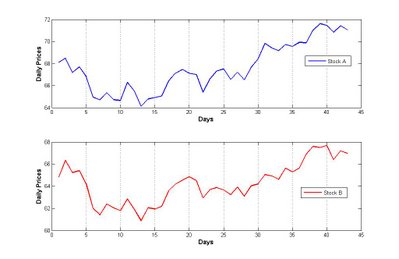

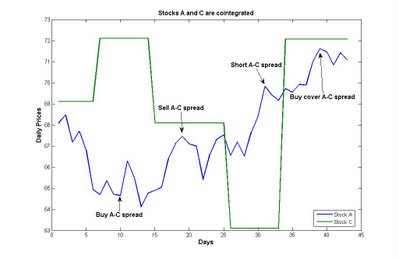

* http://epchan.blogspot.com/2006/11/cointegration-is-not-same-as.html
* https://blog.quantinsti.com/pairs-trading-basics/
* https://kidquant.com/project/pairs-trading-strategies-in-python/


Pairs with stocks in the same sector share the same macro fundamental factors and prevent spurious correlation. However, it may be too restrictive and excludes some pairs opportunities

Use **clustering alogrithms** (such as k-mean or DBScan) to group similar stocks together and trade Pairs with the stocks from the same cluster

* https://blog.quantinsti.com/k-means-clustering-pair-selection-python/
* https://algotrading101.com/learn/cluster-analysis-guide/


---

### **Trading Parameters**
* Stocks Price relationship can be expressed as **price spread** (Stock Price A - Stock Price B) rathan than price ratio (Stock Price A / Stock Price B)

* The average price ratio (arithmetic average over a period) can be replaced by other calculations such as short term **moving average**

* **Improve strategy entry /exit points**: there's no guarantee that the point immediately after crossing the threshold is an optimal entry point. The spread might continue to diverge before converging again.

Can apply **statistical measures** (e.g. diverges by more than two historical standard deviations) or **technincal indicators** (e.g. bollinger bands) or **Machine Learning** (e.g. decision tree, LSTM) to predict the price movements and the entry/exit bands

* **Add Stop Loss** to prevent the stocks pair from diverging too much (may be the underlying relationship is broken due to some external events)

* **Dollar value** for each pair trade can be different but need a way to determine the optimal amount
